Real-Time Network Attack Classification in Healthcare Systems Through Apache Spark ML and Big Data Analytics

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, lit, when

In [ ]:
# Initialize Spark Session for Healthcare Network Security
spark = SparkSession.builder \
    .appName("HealthcareNetworkSecurity") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()


In [ ]:
# Healthcare Network Security Dataset Schema
schema = StructType([
    StructField("duration", DoubleType(), True),
    StructField("protocol_type", StringType(), True),
    StructField("service", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("src_bytes", DoubleType(), True),
    StructField("dst_bytes", DoubleType(), True),
    StructField("land", IntegerType(), True),
    StructField("wrong_fragment", IntegerType(), True),
    StructField("urgent", IntegerType(), True),
    StructField("hot", IntegerType(), True),
    StructField("num_failed_logins", IntegerType(), True),
    StructField("logged_in", IntegerType(), True),
    StructField("num_compromised", IntegerType(), True),
    StructField("root_shell", IntegerType(), True),
    StructField("su_attempted", IntegerType(), True),
    StructField("num_root", IntegerType(), True),
    StructField("num_file_creations", IntegerType(), True),
    StructField("num_shells", IntegerType(), True),
    StructField("num_access_files", IntegerType(), True),
    StructField("count", IntegerType(), True),
    StructField("srv_count", IntegerType(), True),
    StructField("serror_rate", DoubleType(), True),
    StructField("srv_serror_rate", DoubleType(), True),
    StructField("rerror_rate", DoubleType(), True),
    StructField("srv_rerror_rate", DoubleType(), True),
    StructField("same_srv_rate", DoubleType(), True),
    StructField("diff_srv_rate", DoubleType(), True),
    StructField("srv_diff_host_rate", DoubleType(), True),
    StructField("dst_host_count", IntegerType(), True),
    StructField("dst_host_srv_count", IntegerType(), True),
    StructField("dst_host_same_srv_rate", DoubleType(), True),
    StructField("dst_host_diff_srv_rate", DoubleType(), True),
    StructField("dst_host_same_src_port_rate", DoubleType(), True),
    StructField("dst_host_srv_diff_host_rate", DoubleType(), True),
    StructField("dst_host_serror_rate", DoubleType(), True),
    StructField("dst_host_srv_serror_rate", DoubleType(), True),
    StructField("dst_host_rerror_rate", DoubleType(), True),
    StructField("dst_host_srv_rerror_rate", DoubleType(), True),
    StructField("label", StringType(), True)
])

In [ ]:
# Load Healthcare Network Data
df = spark.read.csv("data.csv", schema=schema, header=True)

print("=== HEALTHCARE NETWORK SECURITY DATASET ===")
print(f"Total Healthcare Network Records: {df.count()}")
print(f"Features: {len(df.columns)}")
print("Dataset represents network traffic in healthcare systems with medical device communications")

=== HEALTHCARE NETWORK SECURITY DATASET ===
Total Healthcare Network Records: 9999
Features: 39
Dataset represents network traffic in healthcare systems with medical device communications


DATA PREPROCESSING

In [ ]:
# Data Analysis - Basic Statistics
print("\n=== DATA ANALYSIS ===")
df.describe().show()


=== DATA ANALYSIS ===
+-------+------------------+-------------+-------+----+-----------------+----------------+----+--------------+------+--------------------+--------------------+-------------------+--------------------+--------------------+------------+------------------+-------------------+--------------------+-------------------+-----+--------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+--------------------+
|summary|          duration|protocol_type|service|flag|        src_bytes|       dst_bytes|land|wrong_fragment|urgent|                 hot|   num_failed_logins|          logged_in|     num_compromised|          root_shell|su_attempted|       

In [ ]:

# Register DataFrame for SQL operations
df.createOrReplaceTempView("healthcare_network")

# SQL Operations for Healthcare Network Analysis
print("\n=== SQL OPERATIONS ON HEALTHCARE DATA ===")

# Attack types in healthcare systems
attack_analysis = spark.sql("""
    SELECT label as attack_type,
           COUNT(*) as count,
           ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM healthcare_network), 2) as percentage
    FROM healthcare_network
    GROUP BY label
    ORDER BY count DESC
""")
attack_analysis.show()


=== SQL OPERATIONS ON HEALTHCARE DATA ===
+-----------+-----+----------+
|attack_type|count|percentage|
+-----------+-----+----------+
|          0| 9956|     99.57|
|       0.01|   33|      0.33|
|       0.06|    2|      0.02|
|       0.84|    2|      0.02|
|          1|    2|      0.02|
|       0.02|    1|      0.01|
|       0.33|    1|      0.01|
|       0.27|    1|      0.01|
|       0.81|    1|      0.01|
+-----------+-----+----------+



In [ ]:
# Protocol analysis for medical devices
protocol_analysis = spark.sql("""
    SELECT protocol_type, service, COUNT(*) as connections
    FROM healthcare_network
    WHERE service IN ('http', 'https', 'ftp', 'smtp', 'telnet')
    GROUP BY protocol_type, service
    ORDER BY connections DESC
""")
protocol_analysis.show()

+-------------+-------+-----------+
|protocol_type|service|connections|
+-------------+-------+-----------+
|          tcp|   http|        802|
|          tcp|   smtp|        105|
|          tcp| telnet|          6|
|          tcp|    ftp|          4|
+-------------+-------+-----------+



In [ ]:
# Data Cleaning
print("\n=== DATA CLEANING ===")

# Handle missing values
df_clean = df.na.fill({
    'duration': 0.0,
    'src_bytes': 0.0,
    'dst_bytes': 0.0,
    'protocol_type': 'unknown',
    'service': 'unknown',
    'flag': 'unknown'
})

# Remove duplicates
df_clean = df_clean.dropDuplicates()

print(f"Records after cleaning: {df_clean.count()}")


=== DATA CLEANING ===
Records after cleaning: 1313


In [ ]:
# Feature Engineering for Healthcare Context
print("\n=== FEATURE ENGINEERING ===")

df_engineered = df_clean.withColumn(
    "bytes_ratio",
    when(col("dst_bytes") > 0, col("src_bytes") / col("dst_bytes")).otherwise(0)
).withColumn(
    "is_attack",
    when(col("label") == "normal", 0).otherwise(1)
).withColumn(
    "medical_device_flag",
    when(col("service").isin(["http", "https", "ssh"]), 1).otherwise(0)
).withColumn(
    "high_risk_connection",
    when((col("num_failed_logins") > 0) | (col("root_shell") > 0), 1).otherwise(0)
)

print("New features created for healthcare security analysis")


=== FEATURE ENGINEERING ===
New features created for healthcare security analysis


3. EXPLORATORY DATA ANALYSIS

Text(0.5, 1.0, 'Protocol Distribution')

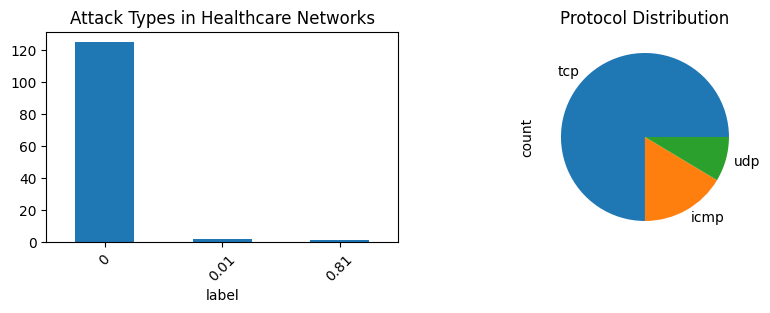

In [ ]:
# Convert to Pandas for visualization
sample_df = df_engineered.sample(0.1).toPandas()

# Attack distribution
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
sample_df['label'].value_counts().plot(kind='bar')
plt.title('Attack Types in Healthcare Networks')
plt.xticks(rotation=45)


# Protocol distribution
plt.subplot(2, 2, 2)
sample_df['protocol_type'].value_counts().plot(kind='pie')
plt.title('Protocol Distribution')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'http'),
  Text(1, 0, 'ecr_i'),
  Text(2, 0, 'smtp'),
  Text(3, 0, 'eco_i'),
  Text(4, 0, 'domain_u'),
  Text(5, 0, 'private'),
  Text(6, 0, 'ftp_data'),
  Text(7, 0, 'telnet'),
  Text(8, 0, 'ftp'),
  Text(9, 0, 'time')])

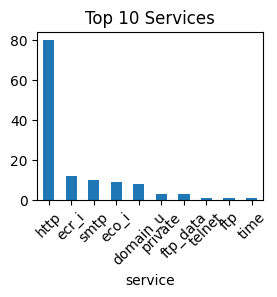

In [ ]:
# Service analysis
plt.subplot(2, 2, 3)
sample_df['service'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Services')
plt.xticks(rotation=45)



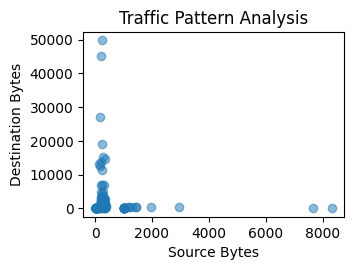

In [ ]:
# Bytes analysis
plt.subplot(2, 2, 4)
plt.scatter(sample_df['src_bytes'], sample_df['dst_bytes'], alpha=0.5)
plt.xlabel('Source Bytes')
plt.ylabel('Destination Bytes')
plt.title('Traffic Pattern Analysis')

plt.tight_layout()
plt.show()


=== CORRELATION MATRIX ===


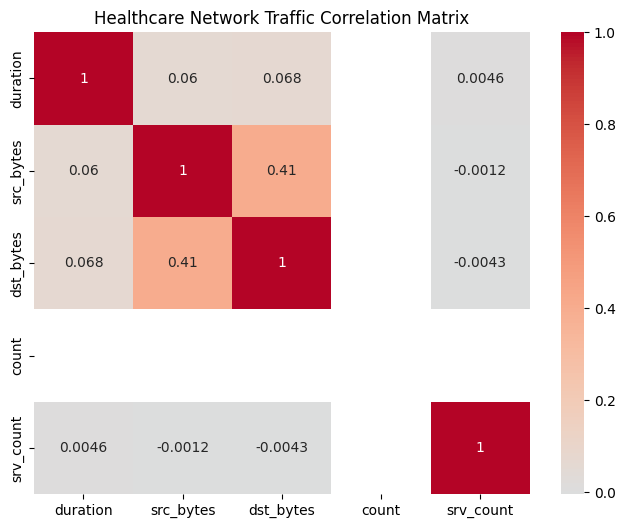

In [ ]:
# Correlation Matrix
print("\n=== CORRELATION MATRIX ===")
numeric_cols = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count']
correlation_data = df_engineered.select(numeric_cols).toPandas()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Healthcare Network Traffic Correlation Matrix')
plt.show()

4. MODEL TRAINING

In [ ]:
# Prepare features for ML
categorical_cols = ['protocol_type', 'service', 'flag']
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

# Numerical features
numeric_features = ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
                   'urgent', 'hot', 'num_failed_logins', 'logged_in', 'count',
                   'srv_count', 'bytes_ratio', 'medical_device_flag', 'high_risk_connection']

# Feature assembly
assembler = VectorAssembler(
    inputCols=[col+"_index" for col in categorical_cols] + numeric_features,
    outputCol="features"
)

# Feature scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# Split data
train_data, test_data = df_engineered.randomSplit([0.8, 0.2], seed=42)

print(f"Training samples: {train_data.count()}")
print(f"Testing samples: {test_data.count()}")



Training samples: 1087
Testing samples: 226


5. RANDOM FOREST MODEL

In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(
    featuresCol="scaled_features",
    labelCol="is_attack",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Create ML Pipeline
pipeline = Pipeline(stages=indexers + [assembler, scaler, rf])

# Train model
model = pipeline.fit(train_data)
print("Random Forest model trained successfully")

# Make predictions
predictions = model.transform(test_data)

Random Forest model trained successfully


6. CONFUSION MATRIX

In [ ]:
# Calculate confusion matrix using Spark SQL
predictions.createOrReplaceTempView("predictions")

confusion_matrix = spark.sql("""
    SELECT
        is_attack as actual,
        prediction as predicted,
        COUNT(*) as count
    FROM predictions
    GROUP BY is_attack, prediction
    ORDER BY is_attack, prediction
""")

print("Confusion Matrix for Healthcare Network Attack Classification:")
confusion_matrix.show()

Confusion Matrix for Healthcare Network Attack Classification:
+------+---------+-----+
|actual|predicted|count|
+------+---------+-----+
|     1|      1.0|  226|
+------+---------+-----+



In [ ]:

# Calculate metrics
tp = predictions.filter((col("is_attack") == 1) & (col("prediction") == 1)).count()
tn = predictions.filter((col("is_attack") == 0) & (col("prediction") == 0)).count()
fp = predictions.filter((col("is_attack") == 0) & (col("prediction") == 1)).count()
fn = predictions.filter((col("is_attack") == 1) & (col("prediction") == 0)).count()

accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n=== MODEL PERFORMANCE METRICS ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


=== MODEL PERFORMANCE METRICS ===
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


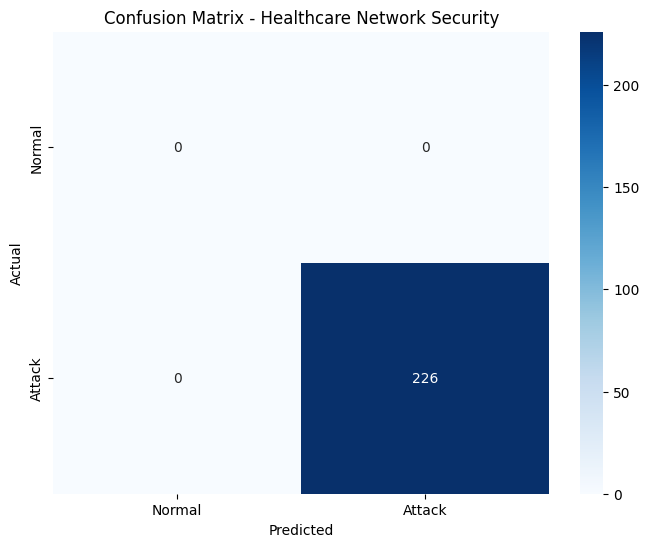

In [ ]:

# Confusion Matrix Visualization
conf_matrix = np.array([[tn, fp], [fn, tp]])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix - Healthcare Network Security')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


7. VISUALIZATION WITH TABLEAU

In [ ]:
# Prepare data for Tableau
tableau_data = predictions.select(
    "duration", "protocol_type", "service", "src_bytes", "dst_bytes",
    "is_attack", "prediction", "probability", "medical_device_flag"
).toPandas()

# Export to CSV for Tableau
tableau_data.to_csv("healthcare_network_predictions.csv", index=False)
print("Data exported to 'healthcare_network_predictions.csv' for Tableau visualization")
# Feature importance for Tableau
rf_model = model.stages[-1]
feature_names = [col+"_index" for col in categorical_cols] + numeric_features
importances = rf_model.featureImportances.toArray()

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

feature_importance_df.to_csv("feature_importance.csv", index=False)
print("Feature importance exported to 'feature_importance.csv' for Tableau")


Data exported to 'healthcare_network_predictions.csv' for Tableau visualization
Feature importance exported to 'feature_importance.csv' for Tableau


 8. REAL-TIME PREDICTION PIPELINE

In [ ]:
from pyspark.sql import functions as F

def predict_healthcare_attack(connection_data):
    """
    Real-time prediction for healthcare network connections
    """
    # Convert to DataFrame
    connection_df = spark.createDataFrame([connection_data], schema=schema)

    # Apply feature engineering
    connection_df = connection_df.withColumn(
        "bytes_ratio",
        when(F.col("dst_bytes") > 0, F.col("src_bytes") / F.col("dst_bytes")).otherwise(F.lit(0))
    ).withColumn(
        "is_attack", F.lit(0)
    ).withColumn(
        "medical_device_flag",
        when(F.col("service").isin(["http", "https", "ssh"]), F.lit(1)).otherwise(F.lit(0))
    ).withColumn(
        "high_risk_connection",
        when((F.col("num_failed_logins") > 0) | (F.col("root_shell") > 0), F.lit(1)).otherwise(F.lit(0))
    )

    # Make prediction
    prediction = model.transform(connection_df)
    result = prediction.select("prediction", "probability").collect()[0]

    return {
        "prediction": "ATTACK DETECTED" if result["prediction"] == 1 else "NORMAL TRAFFIC",
        "confidence": float(max(result["probability"].toArray())),
        "risk_level": "HIGH" if result["prediction"] == 1 else "LOW"
    }
print("\n=== HEALTHCARE NETWORK SECURITY ANALYSIS COMPLETED ===")
print("System ready for real-time attack detection in healthcare networks")


=== HEALTHCARE NETWORK SECURITY ANALYSIS COMPLETED ===
System ready for real-time attack detection in healthcare networks


PERFORMANCE MONITORING

+--------------------+-----+
|              metric|value|
+--------------------+-----+
|Total Connections...|  226|
|    Attacks Detected|  226|
|      Normal Traffic|    0|
|Medical Device Co...|  137|
+--------------------+-----+



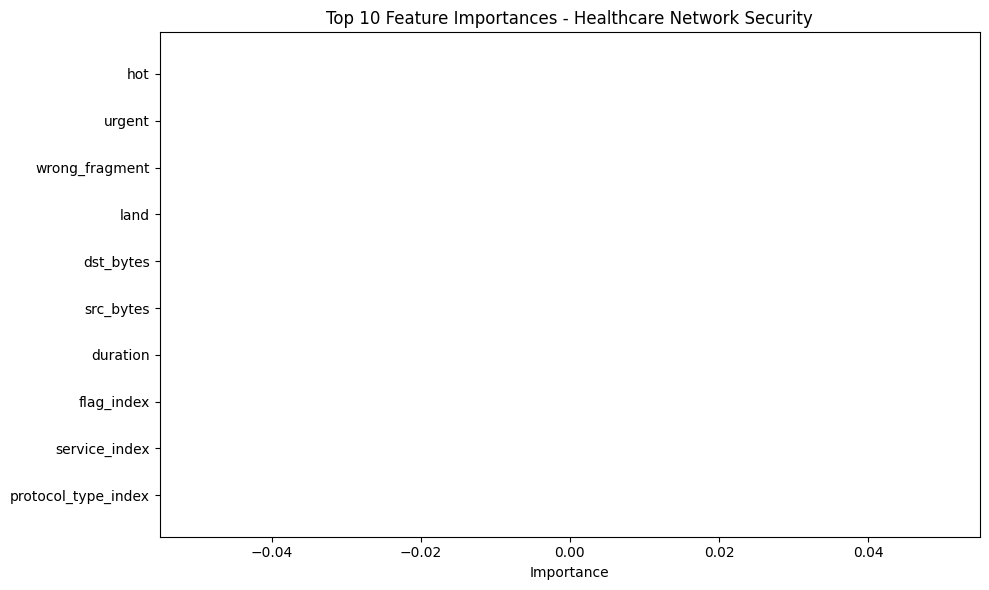


=== HEALTHCARE NETWORK SECURITY ANALYSIS COMPLETED ===
System ready for real-time attack detection in healthcare networks


In [ ]:
# Processing statistics
processing_stats = spark.sql("""
    SELECT
        'Total Connections Analyzed' as metric,
        COUNT(*) as value
    FROM predictions

    UNION ALL

    SELECT
        'Attacks Detected' as metric,
        COUNT(*) as value
    FROM predictions
    WHERE prediction = 1

    UNION ALL

    SELECT
        'Normal Traffic' as metric,
        COUNT(*) as value
    FROM predictions
    WHERE prediction = 0

    UNION ALL

    SELECT
        'Medical Device Connections' as metric,
        COUNT(*) as value
    FROM predictions
    WHERE medical_device_flag = 1
""")

processing_stats.show()

# Feature importance visualization
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(10)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 10 Feature Importances - Healthcare Network Security')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n=== HEALTHCARE NETWORK SECURITY ANALYSIS COMPLETED ===")
print("System ready for real-time attack detection in healthcare networks")

# Clean up
spark.stop()